## Reading mitab data from psicquic
* [Requests API](https://requests.readthedocs.io/en/master/)

In [1]:
proxies = {
  'http': 'http://ftprox.ibcp.fr:3128',
  'https': 'http://ftprox.ibcp.fr:3128',
}

In [2]:
import requests

psicquicProviderURL="http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search"
miqlMethod="query"
miqlField="pubid"
miqlValue="17446270"

miqlRequest= f"{psicquicProviderURL}/{miqlMethod}/{miqlField}:{miqlValue}"

print(miqlRequest)

try:
    httpReq = requests.get(miqlRequest, proxies=proxies)
except NameError:
    httpReq = requests.get(miqlRequest)

ans = httpReq.text

http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/pubid:17446270


In [62]:
psqData = [ _.split("\t") for _ in ans.split("\n") if len(_.split("\t")) > 1]
    
_ = len(psqData[0])
for psqDatum in psqData:
    assert len(psqDatum) == _
print(f"Total number of interaction data {len(psqData)}")

# Remove all psicquic entry not mapped to a uniprot ID
psqData = [ ok for ok in filter( lambda x:x[0].startswith("uniprotkb:") and x[1].startswith("uniprotkb:"), psqData ) ]

psqData[-1]


Total number of interaction data 232


['uniprotkb:P0C722',
 'uniprotkb:Q12933',
 'intact:EBI-2623029|uniprotkb:Q777E3',
 'intact:EBI-355744|uniprotkb:A8K107|uniprotkb:B4DPJ7|uniprotkb:Q7Z337|dip:DIP-6223N|intact:EBI-1046651|uniprotkb:Q96NT2',
 'psi-mi:brrf1_ebvg(display_long)|uniprotkb:BRRF1(orf name)',
 'psi-mi:traf2_human(display_long)|uniprotkb:Tumor necrosis factor type 2 receptor-associated protein 3(gene name synonym)|uniprotkb:E3 ubiquitin-protein ligase TRAF2(gene name synonym)|uniprotkb:RING-type E3 ubiquitin transferase TRAF2(gene name synonym)|uniprotkb:TRAF2(gene name)|psi-mi:TRAF2(display_short)|uniprotkb:TRAP3(gene name synonym)',
 'psi-mi:"MI:0018"(two hybrid)',
 'Calderwood et al. (2007)',
 'pubmed:17446270|imex:IM-20435|mint:MINT-6769080',
 'taxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")',
 'taxid:9606(human)|taxid:9606(Homo sapiens)',
 'psi-mi:"MI:0915"(physical association)',
 'psi-mi:"MI:0469"(IntAct)',
 'intact:EBI-2644156|imex:IM-20435-230',
 'intact-miscore:0.37']

### Build EBV self interactome
#### With Uniprot identifiers
[NetworkX Draw](https://networkx.github.io/documentation/latest/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx)

In [53]:
# Parameters: uniprotID{String}, root{xmlNode}
# Returns: GeneName{String}
def geneName(uniprotID, root):
    ns = '{http://uniprot.org/uniprot}' 
    for entry in root.findall(ns+'entry'):
        accessions = entry.findall(ns+"accession")
        for acc in accessions:
            if acc.text == uniprotID:
                gene = entry.find(ns+"gene")
                if not gene:
                    return uniprotID
                name = gene.find(ns+"name")
                return name.text
    raise ValueError(uniprotID)

In [64]:
import networkx as nx
import re

reEBV   = "taxid:(1037[6-7]|82830)"
reHuman = "taxid:9606"
EBV_psqData      = []
HumanEBV_psqData = []

G = nx.Graph()

for psqDatum in psqData:
    if re.search(reEBV, psqDatum[9]) and re.search(reEBV, psqDatum[10]):
        G.add_edge(psqDatum[0].replace("uniprotkb:", ""), psqDatum[1].replace("uniprotkb:", "") )
        EBV_psqData.append(psqDatum)
    else:
        HumanEBV_psqData.append(psqDatum)
        
len(EBV_psqData)



59

In [35]:
%matplotlib nbagg
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


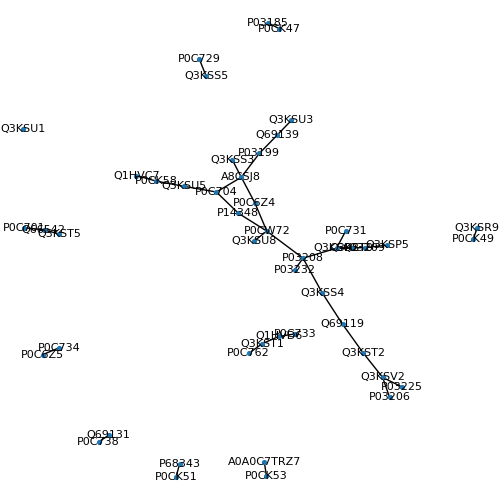

In [58]:
plt.figure(figsize=(5, 5))
nx.draw(G, with_labels=True, node_size=3, font_size=8, linewidths=2)

In [33]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree
    
tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()    

geneLabels = {}
for node in G.nodes():
    #print(node)
    geneLabels[node] = geneName(node, root)

geneLabels

{'P0CW72': 'BARF1',
 'P0C704': 'MCP',
 'P14348': 'SCP',
 'P03185': 'NEC2',
 'P0CK47': 'NEC1',
 'P0C731': 'BGLF4',
 'Q3KSQ2': 'TK',
 'P0CK53': 'BGLF2',
 'A0A0C7TRZ7': 'BSLF1',
 'Q3KST5': 'BLRF2',
 'Q66542': 'BNRF1',
 'Q3KSS4': 'EBNA1',
 'P03209': 'BRLF1',
 'Q3KSP5': 'LF2',
 'Q3KSU8': 'BPLF1',
 'Q3KSU1': 'BMLF1',
 'Q3KSV2': 'EBNA2',
 'P03206': 'BZLF1',
 'Q3KST2': 'EBNA3',
 'P03225': 'BDLF2',
 'Q3KSU5': 'RIR1',
 'P0C729': 'LMP2',
 'Q3KSS5': 'BRRF2',
 'Q69119': 'Q69119',
 'Q3KST0': 'EBNA6',
 'P0CK58': 'BALF1',
 'P03208': 'BILF1',
 'Q69131': 'BN-LF2a',
 'P0C738': 'BNLF2a',
 'P0C701': 'RIR2',
 'Q1HVC7': 'BVRF2',
 'P0CK49': 'BSRF1',
 'Q3KSR9': 'BBRF1',
 'P0C734': 'BTRF1',
 'P0C6Z5': 'BZLF2',
 'Q3KSS3': 'gL',
 'A8CSJ8': 'LMP1',
 'P68343': 'BLLF1',
 'P0CK51': 'BBLF1',
 'P03199': 'BLLF2',
 'Q69139': 'Q69139',
 'P0C6Z4': 'gN',
 'Q3KSU3': 'BMRF1',
 'P03232': 'BXRF1',
 'Q3KST1': 'EBNA4',
 'P0C762': 'gB',
 'P0C733': 'BNLF2b',
 'Q1HVD6': 'TRX2'}

<IPython.core.display.Javascript object>


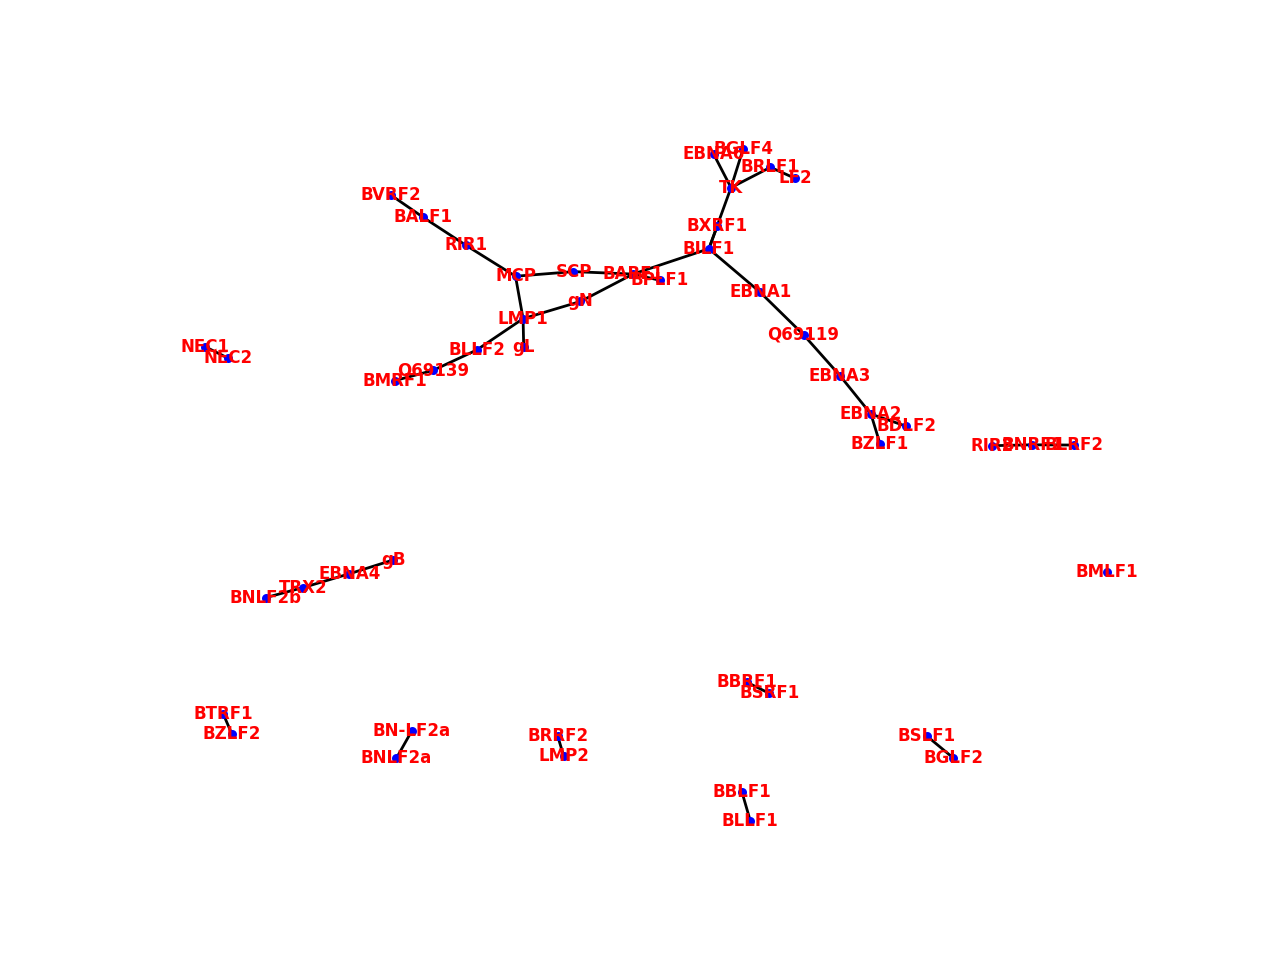

In [48]:
plt.figure()
plt.axis('off')

#pos=nx.draw(G, with_labels=False)
pos=nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=5, node_color="blue")
nx.draw_networkx_labels(G,pos,geneLabels,font_size=6,font_weight=800,font_color='r')
nx.draw_networkx_edges(G, pos)

In [ ]:
# Draw the EBV-human interactome w/ label only on human genes
# square and circle symbols for human and EBV genes respectively


In [67]:
G2 = nx.Graph()
humanGeneLabels = {}
EBV_nodeList = []
for psqDatum in HumanEBV_psqData:
    #print(psqDatum)
    (a, b) = ( psqDatum[0].replace("uniprotkb:", ""), psqDatum[1].replace("uniprotkb:", "") )
    G2.add_edge(a, b)
    (a,b) = (a,b) if re.search(reHuman, psqDatum[9]) else (b,a)
    EBV_nodeList.append(b)
    humanGeneLabels[a] = None

tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()    
for humanID in humanGeneLabels.keys():
    humanGeneLabels[humanID] = geneName(humanID, root)
#humanGeneLabels


<IPython.core.display.Javascript object>


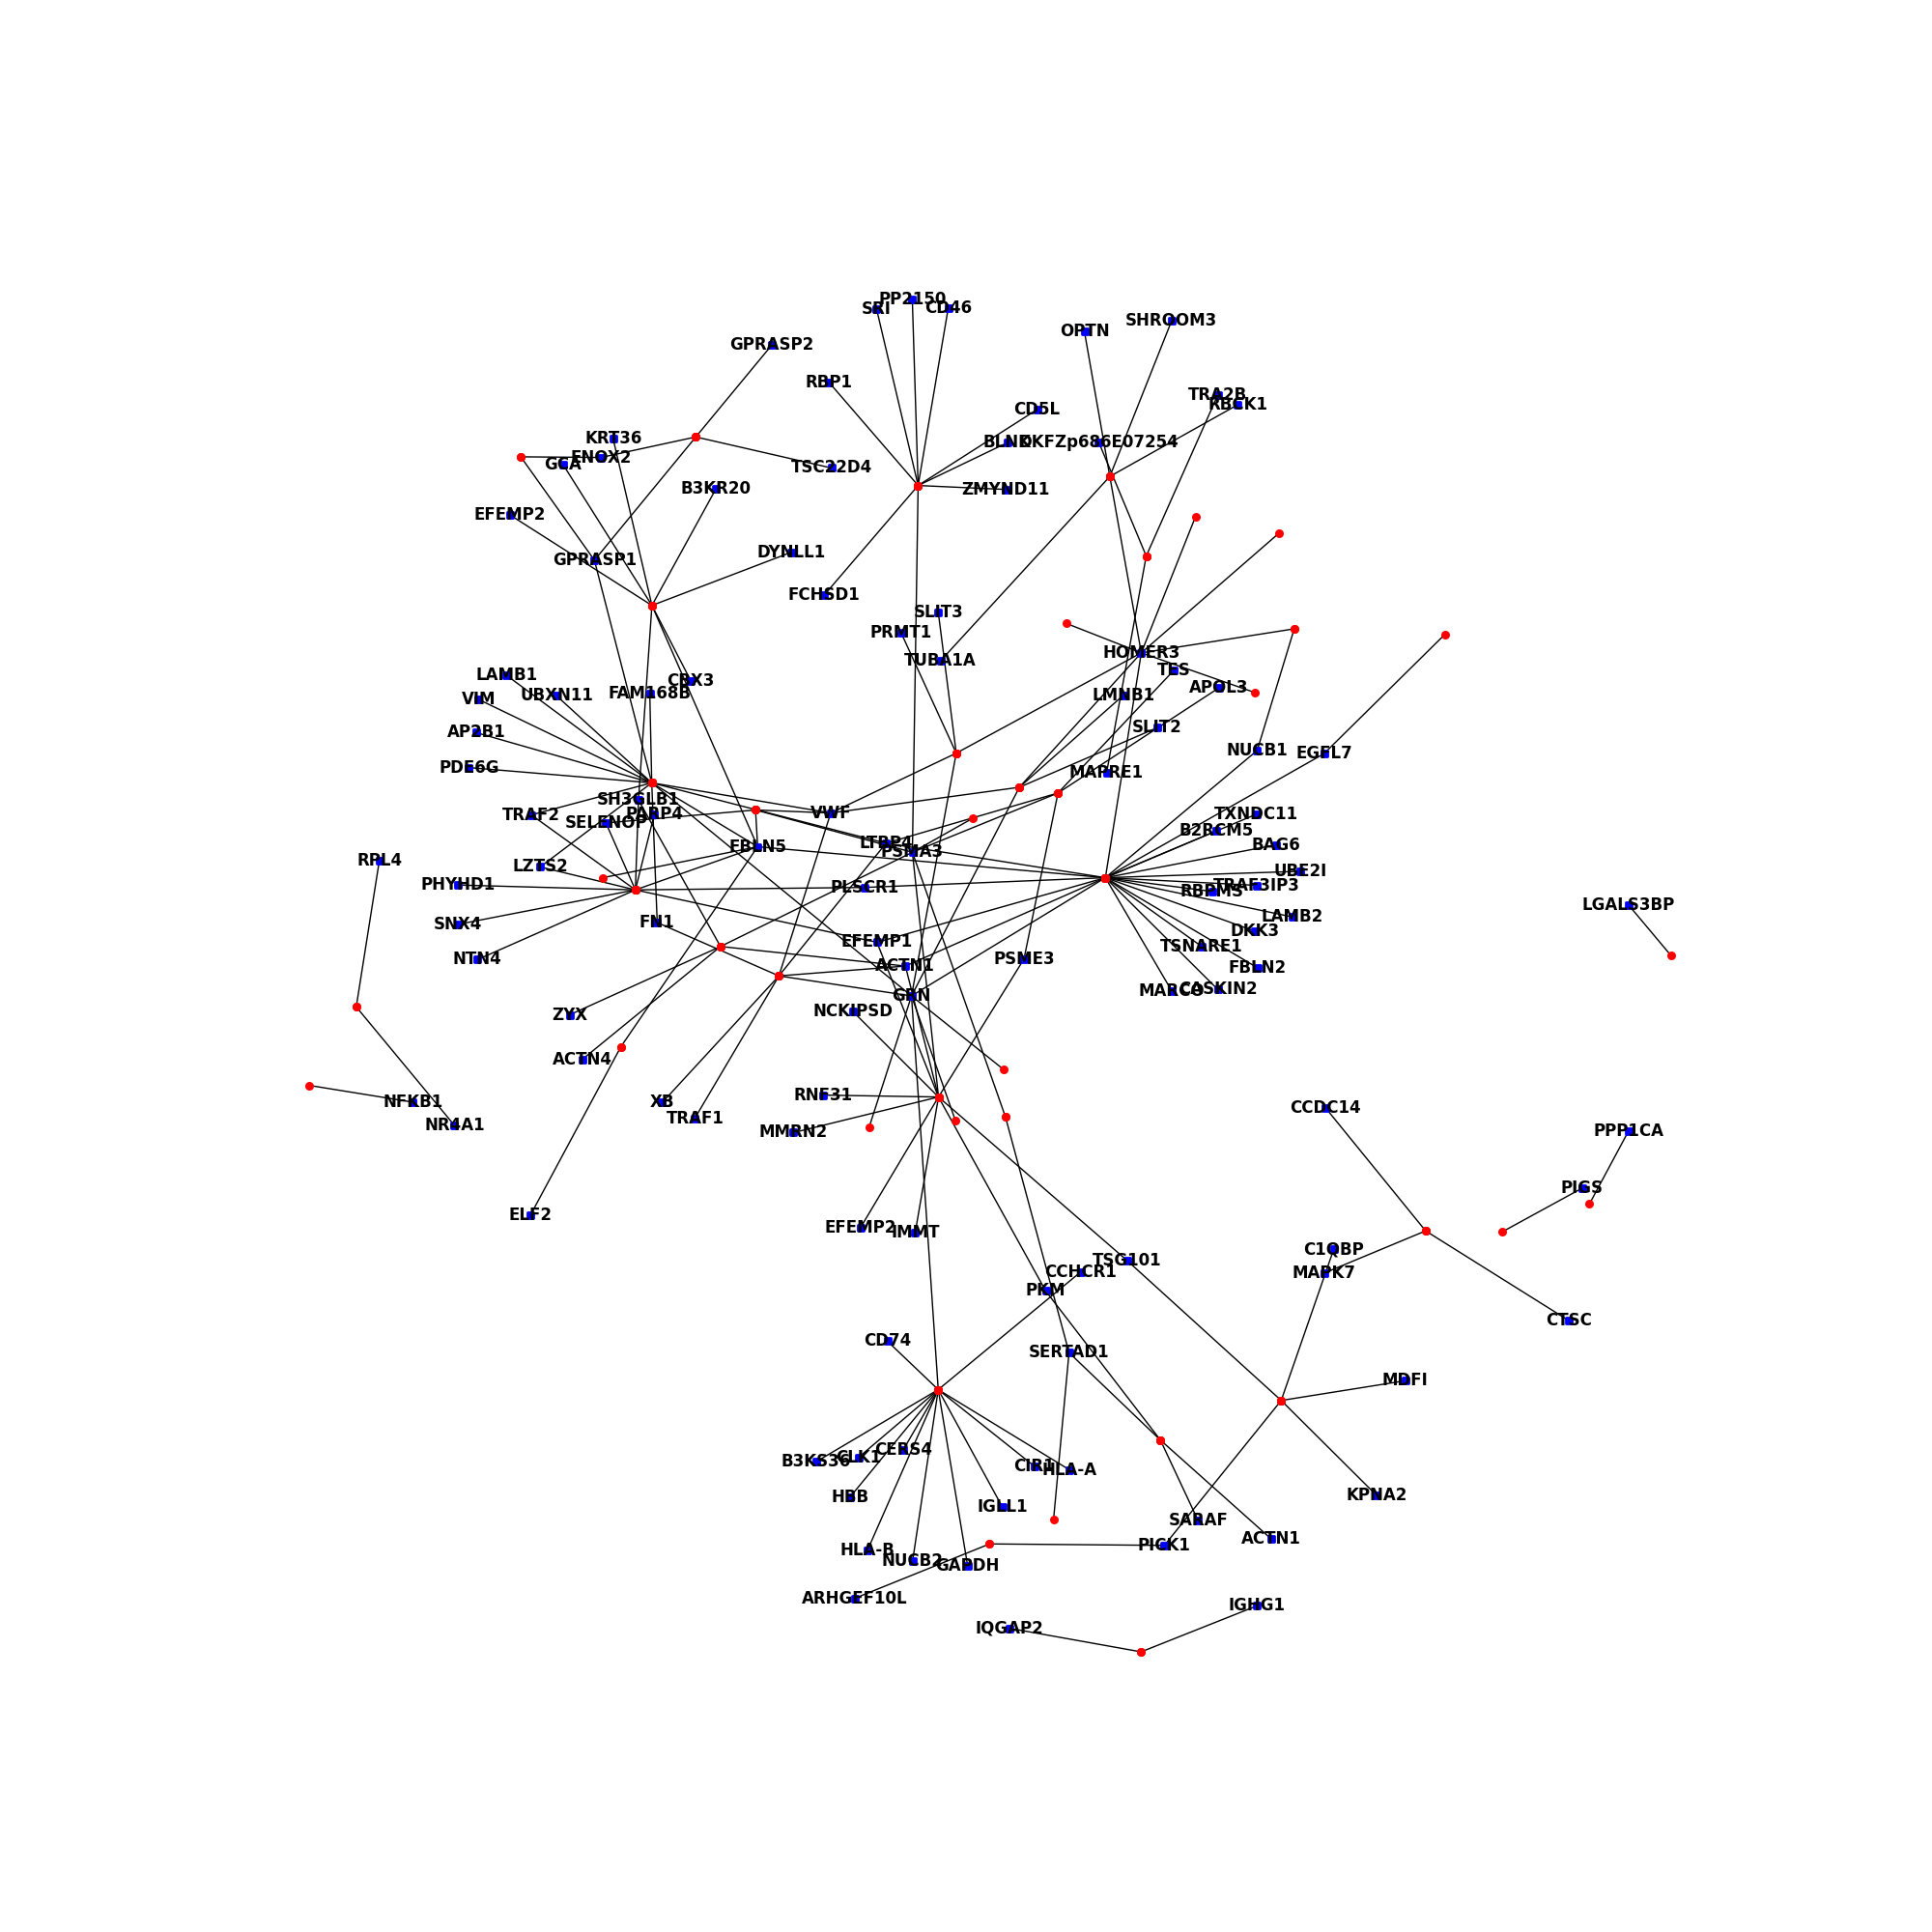

In [88]:
plt.figure(figsize=(10, 10))
plt.axis('off')

#pos=nx.draw(G, with_labels=False)
pos=nx.spring_layout(G2, k= 0.225)

nx.draw_networkx_nodes(G2, pos, node_size=5, node_color="blue", node_shape="s",nodelist=humanGeneLabels.keys())
nx.draw_networkx_nodes(G2, pos, node_size=5, node_color="red", node_shape="o",nodelist=EBV_nodeList)
nx.draw_networkx_labels(G2,pos,humanGeneLabels,font_size=6,font_weight=800,font_color='black')
nx.draw_networkx_edges(G2, pos, width=0.5)

## XML data preparation steps
##### Generation of:
* EBV uniprot entries in `Calderwood_EBV_proteome.xml`
* Human uniprot entries in `Calderwood_Human_proteome.xml`

### Get EBV xml Entries
* extract uniprot ID from mitab
* fetch individual uniprot xml
* Collect them in a single `Calderwood_EBV_proteome.xml` file

In [33]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree


#Fetch Xml document from uniprot

EBV_entryName = []
for psqDatum in EBV_psqData:
    EBV_entryName += [ _.replace("uniprotkb:", "") for _ in psqDatum[:2] ]

print(f"{len(EBV_psqData)} EBV-only psq data found {len(set(EBV_entryName))} EBV entries")
for psqDatum in HumanEBV_psqData:
    if re.search(reEBV, psqDatum[9]):
        EBV_entryName.append( psqDatum[0].replace("uniprotkb:", "") )
    elif re.search(reEBV, psqDatum[10]):
        EBV_entryName.append( psqDatum[1].replace("uniprotkb:", "") )
    else :
        raise ValueError(psqDatum)
    
EBV_entryName = set(EBV_entryName)

print(f"{len(EBV_psqData)} EBV-only & {len(HumanEBV_psqData)} EBV-Human psq data found {len(EBV_entryName)} EBV entries")

xmlRawDoc = []
for uniprotID in EBV_entryName:
    xmlRequest=f"https://www.uniprot.org/uniprot/{uniprotID}.xml"
    try:
        httpReq = requests.get(xmlRequest, proxies=proxies)
    except NameError:
        httpReq = requests.get(xmlRequest)

    xmlRawDoc.append(httpReq.text)


59 EBV-only psq data found 48 EBV entries
59 EBV-only & 173 EBV-Human psq data found 64 EBV entries


In [34]:
register_namespace('', "http://uniprot.org/uniprot")
ns = '{http://uniprot.org/uniprot}'
collectionHolder = '<?xml version="1.0" encoding="UTF-8"?>\n<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd"></uniprot>'
collection = fromstring(collectionHolder)

for _ in xmlRawDoc:
    tree = fromstring(_)
    collection.append(tree.find(ns+"entry"))

    _= f"{ns}entry"
print( f"initial number of xml document {len(xmlRawDoc)} found {len( collection.findall(_))} uniprot entries")
tree = ElementTree(collection)
tree.write("./data/Calderwood_EBV_proteome.xml")

initial number of xml document 64 found 64 uniprot entries


### Get Human xml Entries
* extract uniprot ID from mitab
* fetch individual uniprot xml
* Collect them in a single `Calderwood_Human_proteome.xml` file


In [55]:
humanEntryName = []
for psqDatum in HumanEBV_psqData:   
    if re.search(reHuman, psqDatum[9]):
        humanEntryName.append( psqDatum[0].replace("uniprotkb:", "") if  psqDatum[0].startswith("uniprotkb:") else  psqDatum[2].replace("uniprotkb:", ""))
    elif re.search(reHuman, psqDatum[10]):
         humanEntryName.append( psqDatum[1].replace("uniprotkb:", "") if  psqDatum[1].startswith("uniprotkb:") else  psqDatum[3].replace("uniprotkb:", ""))
    else :
        raise ValueError(psqDatum)
    if humanEntryName[-1] == '-': # Two mappings to uniprot are incorrect, we would need to go through gene name to rescue them
        humanEntryName = humanEntryName[:-1]

humanEntryName = set(humanEntryName)

print(f"{len(HumanEBV_psqData)} EBV-Human psq data found {len(humanEntryName)} human entries")

xmlRawDoc = []
for uniprotID in humanEntryName:
    xmlRequest=f"https://www.uniprot.org/uniprot/{uniprotID}.xml"
    try:
        httpReq = requests.get(xmlRequest, proxies=proxies)
    except NameError:
        httpReq = requests.get(xmlRequest)

    xmlRawDoc.append(httpReq.text)


173 EBV-Human psq data found 113 human entries


In [57]:
register_namespace('', "http://uniprot.org/uniprot")
ns = '{http://uniprot.org/uniprot}'
collectionHolder = '<?xml version="1.0" encoding="UTF-8"?>\n<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd"></uniprot>'
collection = fromstring(collectionHolder)

for _, n in zip(xmlRawDoc, humanEntryName):
#    print(n,"-->", _)
    tree = fromstring(_)
    collection.append(tree.find(ns+"entry"))

    _= f"{ns}entry"
print( f"initial number of xml document {len(xmlRawDoc)} found {len( collection.findall(_))} uniprot entries")
tree = ElementTree(collection)
tree.write("./data/Calderwood_Human_proteome.xml")

initial number of xml document 113 found 113 uniprot entries
